In [2]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from imblearn.over_sampling import SMOTE
from skorch import NeuralNetBinaryClassifier
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('../data/preprocessed_data/TelcoCustomerChurn_Preprocessed.csv')

In [3]:
# Separate features and target variable
X = data.drop(['Churn', 'CustomerID'], axis=1)
y = data['Churn']
print(y.value_counts()[0], y.value_counts()[1])

X, y = SMOTE().fit_resample(X, y)
print(y.value_counts()[0], y.value_counts()[1])

5163 1869
5163 5163


In [4]:
# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.1):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size / 2)) 
        self.bn2 = nn.BatchNorm1d(int(hidden_size / 2))
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(int(hidden_size / 2), 1)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
auc_scores, accuracies, precisions, recalls, f1_scores = [], [], [], [], []

all_true_labels = []
all_predictions = []
all_prob_predictions = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f'Fold {fold + 1}')

    # Splitting data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    # DataLoader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

    # Model instantiation
    input_size = X_train.shape[1]
    print(X_train.shape[1])
    hidden_size = 128
    dropout_rate = 0.3
    model = NeuralNetwork(input_size, hidden_size, dropout_rate)

    # Loss function, optimizer, and scheduler
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Training loop
    epochs = 100
    for epoch in range(epochs):
        model.train()
        for batch, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()        
            loss = criterion(outputs, labels).mean()
            
            loss.backward()
            optimizer.step()

        scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor).squeeze()
    
        predictions = outputs >= 0.5
        predictions = predictions.int()

        # Calculate metrics
        auc_score = roc_auc_score(y_val_tensor, outputs)
        accuracy = accuracy_score(y_val_tensor, predictions)
        precision = precision_score(y_val_tensor, predictions)
        recall = recall_score(y_val_tensor, predictions)
        f1 = f1_score(y_val_tensor, predictions)

        # Store the metrics of the fold
        auc_scores.append(auc_score)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        all_true_labels.extend(y_val_tensor.tolist())
        all_predictions.extend(predictions.tolist())
        all_prob_predictions.extend(outputs.tolist())        

# Average metrics over all folds
print(f"Average AUC Score: {np.mean(auc_scores)}")
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average Precision: {np.mean(precisions)}")
print(f"Average Recall: {np.mean(recalls)}")
print(f"Average F1 Score: {np.mean(f1_scores)}")

Fold 1
45
Fold 2
45
Fold 3
45
Fold 4
45
Fold 5
45
Average AUC Score: 0.8694859915978711
Average Accuracy: 0.7785191348923772
Average Precision: 0.813012961837617
Average Recall: 0.7240825862173026
Average F1 Score: 0.7657024276896467


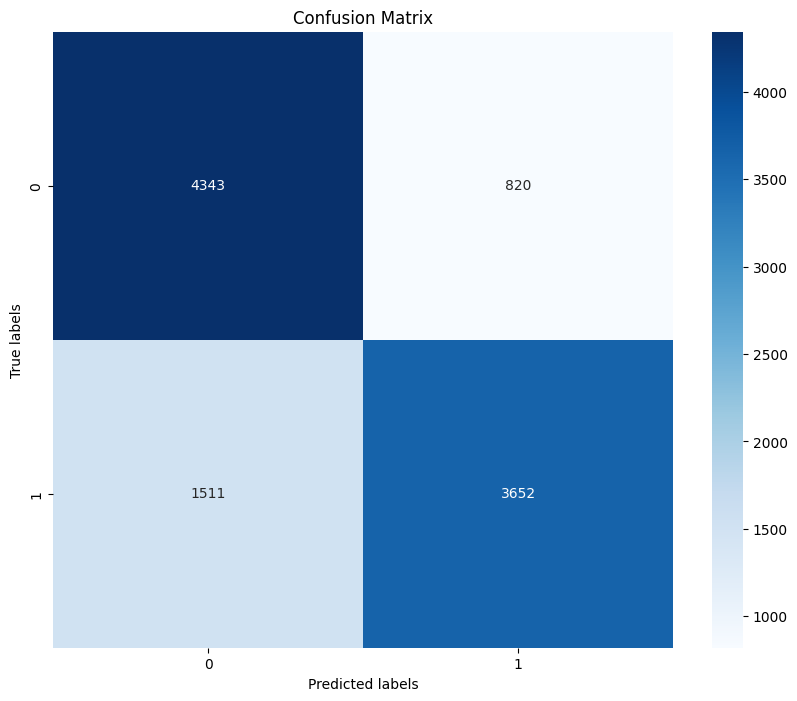

In [28]:
# Result visulizations

conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

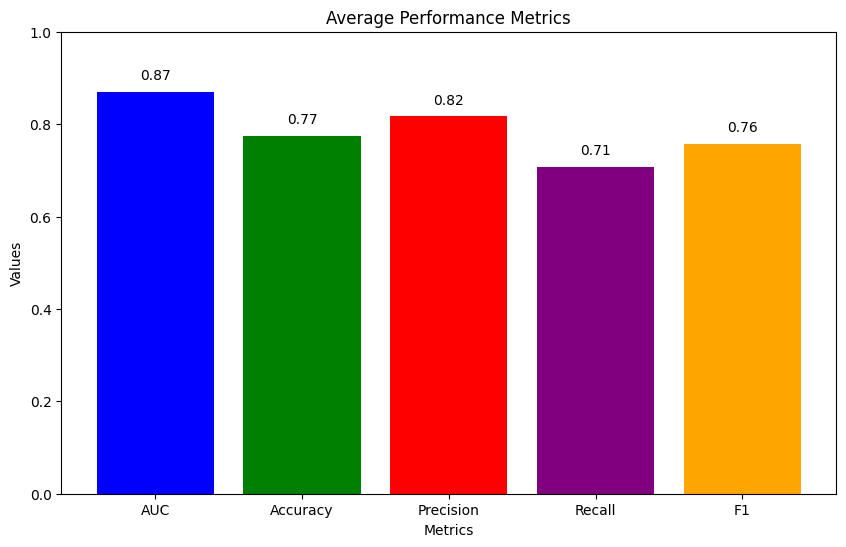

In [29]:
import matplotlib.pyplot as plt

# Calculate average metrics
average_auc = np.mean(auc_scores)
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1_scores)

# Metrics names and their values
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
values = [average_auc, average_accuracy, average_precision, average_recall, average_f1]

# Creating bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Average Performance Metrics')
plt.ylim(0, 1)  # Assuming metric values are between 0 and 1
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

plt.show()

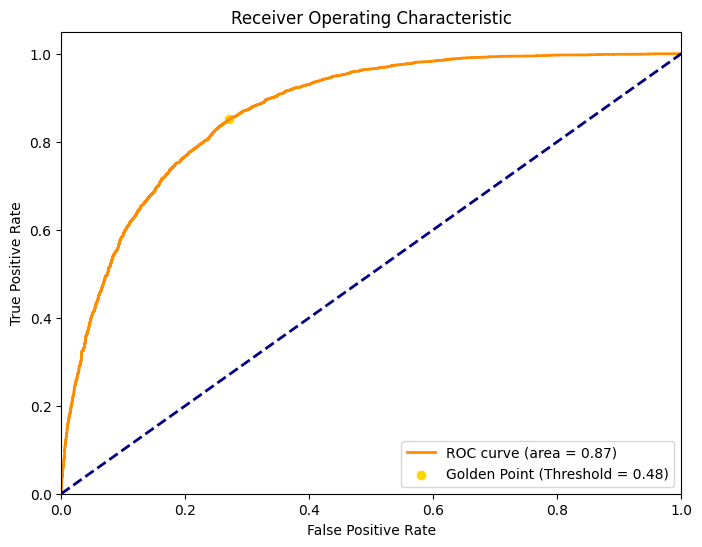

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import math

# Assuming `all_true_labels` and `all_prob_predictions` contain the aggregated true labels and predicted probabilities from all folds
fpr, tpr, thresholds = roc_curve(all_true_labels, all_prob_predictions)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold (golden point)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_logit = thresholds[optimal_idx]
probability_threshold = 1 / (1 + math.exp(-optimal_threshold_logit))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='gold', label=f'Golden Point (Threshold = {probability_threshold:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

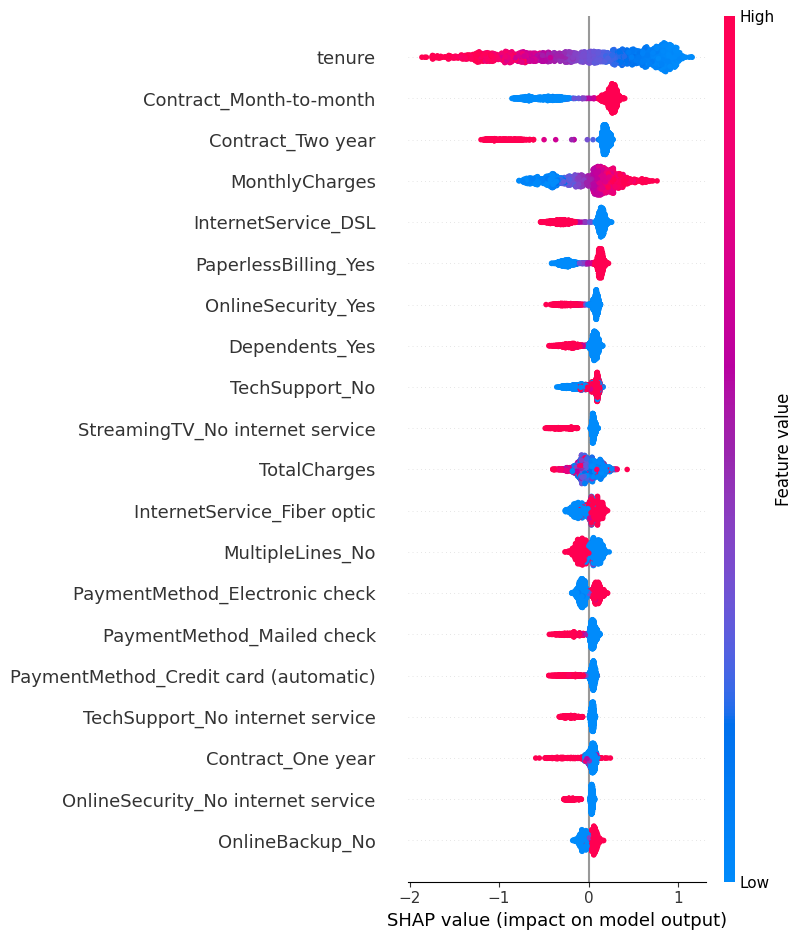

In [53]:
import shap

background = X_train_tensor

explainer = shap.DeepExplainer(model, background)

shap_values = explainer.shap_values(X_val_tensor)

shap_matrix = np.array(shap_values)

if len(shap_matrix.shape) == 1:    
    shap_matrix = shap_matrix.reshape(1, -1)

X_val_numpy = X_val_tensor.detach().numpy()
if len(X_val_numpy.shape) == 1:    
    X_val_numpy = X_val_numpy.reshape(1, -1)

feature_names = X.columns.tolist()

shap.summary_plot(shap_matrix, X_val_numpy, feature_names=feature_names)
